In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno
import matplotlib.cm as cm

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#for nlp
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import scipy.cluster.hierarchy as sch


import warnings
warnings.filterwarnings('ignore')


In [186]:
file_path = r'C:\Users\harsh\Downloads\netflix_titles.csv'
dff = pd.read_csv(file_path)

In [187]:
df = pd.read_csv(file_path)
df.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

In [188]:
df.shape
print(f'Dataset having {df.shape[0]} rows and {df.shape[1]} columns')

Dataset having 8807 rows and 12 columns


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [190]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [191]:
for i in range(len(df.isnull().sum())):
    if df.isnull().sum()[i] > 0:
        print('Total Number of missing values in ' + df.isnull().sum().index[i] + ' : ',df.isnull().sum()[i])

Total Number of missing values in director :  2634
Total Number of missing values in cast :  825
Total Number of missing values in country :  831
Total Number of missing values in date_added :  10
Total Number of missing values in rating :  4
Total Number of missing values in duration :  3


In [192]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [193]:
def DataInfoAll(df):
    print(f"Dataset Shape: {df.shape}")
    print("-"*125)
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    return summary

In [194]:
DataInfoAll(df)

Dataset Shape: (8807, 12)
-----------------------------------------------------------------------------------------------------------------------------


Name  dtypes  Missing  Uniques  \
0        show_id  object        0     8807   
1           type  object        0        2   
2          title  object        0     8807   
3       director  object     2634     4528   
4           cast  object      825     7692   
5        country  object      831      748   
6     date_added  object       10     1767   
7   release_year   int64        0       74   
8         rating  object        4       17   
9       duration  object        3      220   
10     listed_in  object        0      514   
11   description  object        0     8775   

                                          First Value  \
0                                                  s1   
1                                               Movie   
2                                Dick Johnson Is Dead   
3                                     Kirsten Johnson   
4                                                 NaN   
5                                       United States   
6                                  September 25, 2021   
7                                                2020   
8                                               PG-13   
9                                              90 min   
10                                      Documentaries   
11  As her father nears the end of his life, filmm...   

                                         Second Value  
0                                                  s2  
1                                             TV Show  
2                                       Blood & Water  
3                                                 NaN  
4   Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...  
5                                        South Africa  
6                                  September 24, 2021  
7                                                2021  
8                                               TV-MA  
9                                           2 Seasons  
10    International TV Shows, TV Dramas, TV Mysteries  
11  After crossing paths at a party, a Cape Town t...

In [195]:
df_duplicate = df[df.duplicated()]
print("Let's print all the duplicated rows as a dataframe")
df_duplicate

Let's print all the duplicated rows as a dataframe


Empty DataFrame
Columns: [show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description]
Index: []

This dataset have no duplicate values

# **Data Cleaning**

In [196]:
NaN_Checker = pd.DataFrame({"No Of Total Values": df.shape[0] , "No of NaN values": df.isnull().sum(),
                    "%age of NaN values" : round((df.isnull().sum()/ df.shape[0])*100 , 2) })
NaN_Checker.sort_values("No of NaN values" , ascending = False)

No Of Total Values  No of NaN values  %age of NaN values
director                    8807              2634               29.91
country                     8807               831                9.44
cast                        8807               825                9.37
date_added                  8807                10                0.11
rating                      8807                 4                0.05
duration                    8807                 3                0.03
show_id                     8807                 0                0.00
type                        8807                 0                0.00
title                       8807                 0                0.00
release_year                8807                 0                0.00
listed_in                   8807                 0                0.00
description                 8807                 0                0.00

In [197]:
plot_nan = df.isna()
plot_nan.head(2)

show_id   type  title  director   cast  country  date_added  release_year  \
0    False  False  False     False   True    False       False         False   
1    False  False  False      True  False    False       False         False   

   rating  duration  listed_in  description  
0   False     False      False        False  
1   False     False      False        False

In [198]:
missing_val_count = df.isnull().sum()

<BarContainer object of 12 artists>

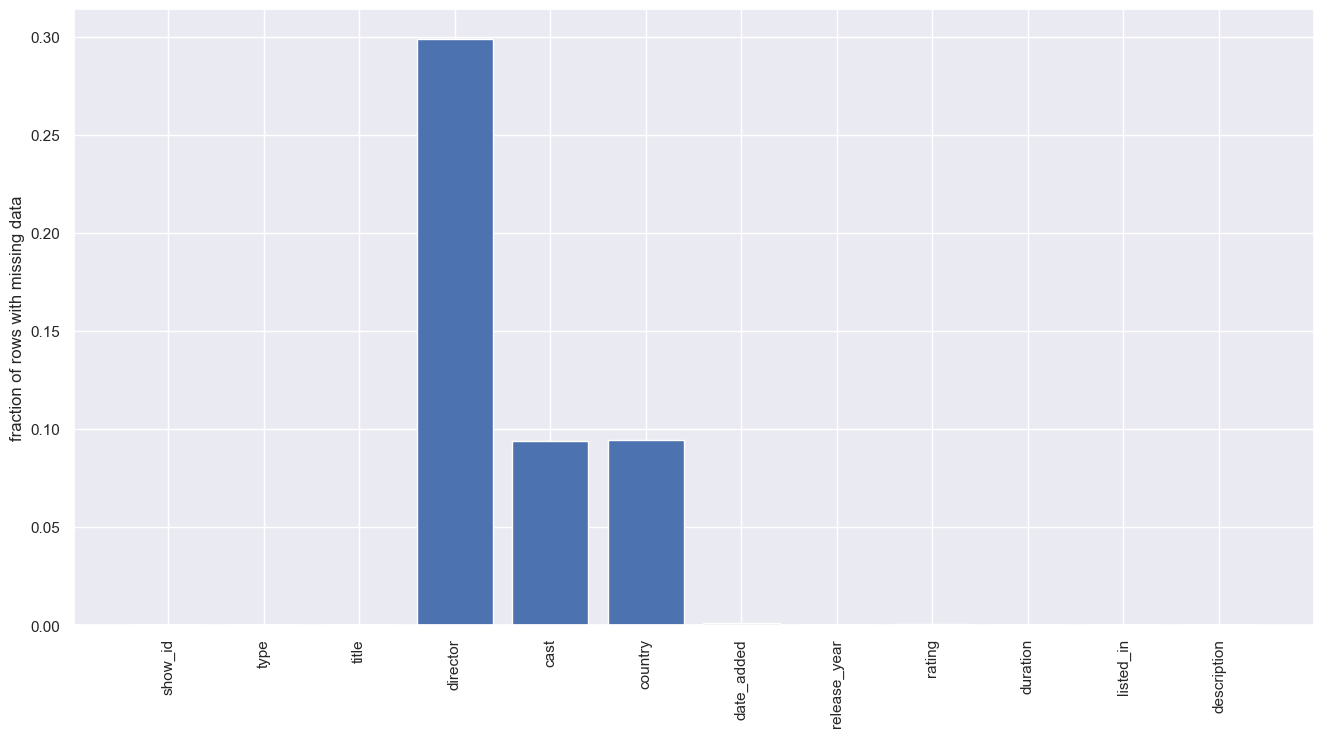

In [199]:
# null value distribution
null_counts = df.isnull().sum()/len(df)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts)),null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

<Axes: >

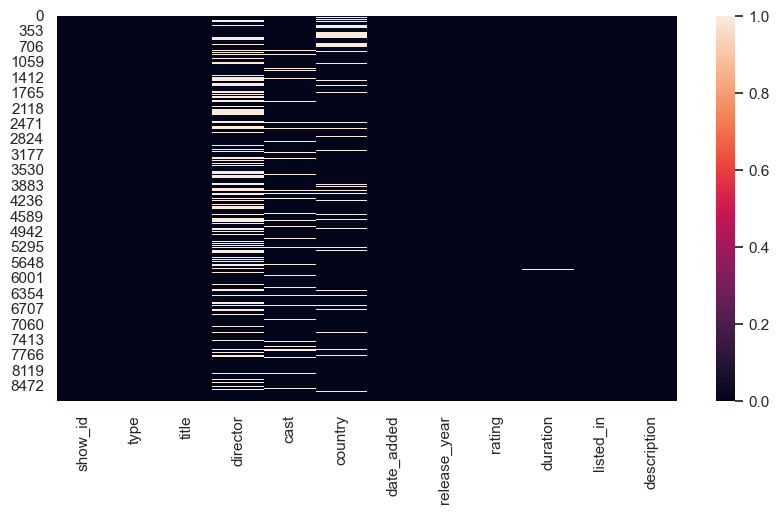

In [200]:
plt.figure( figsize = (10 , 5))
sns.heatmap(plot_nan)

# **Exploratory Data Analysis**

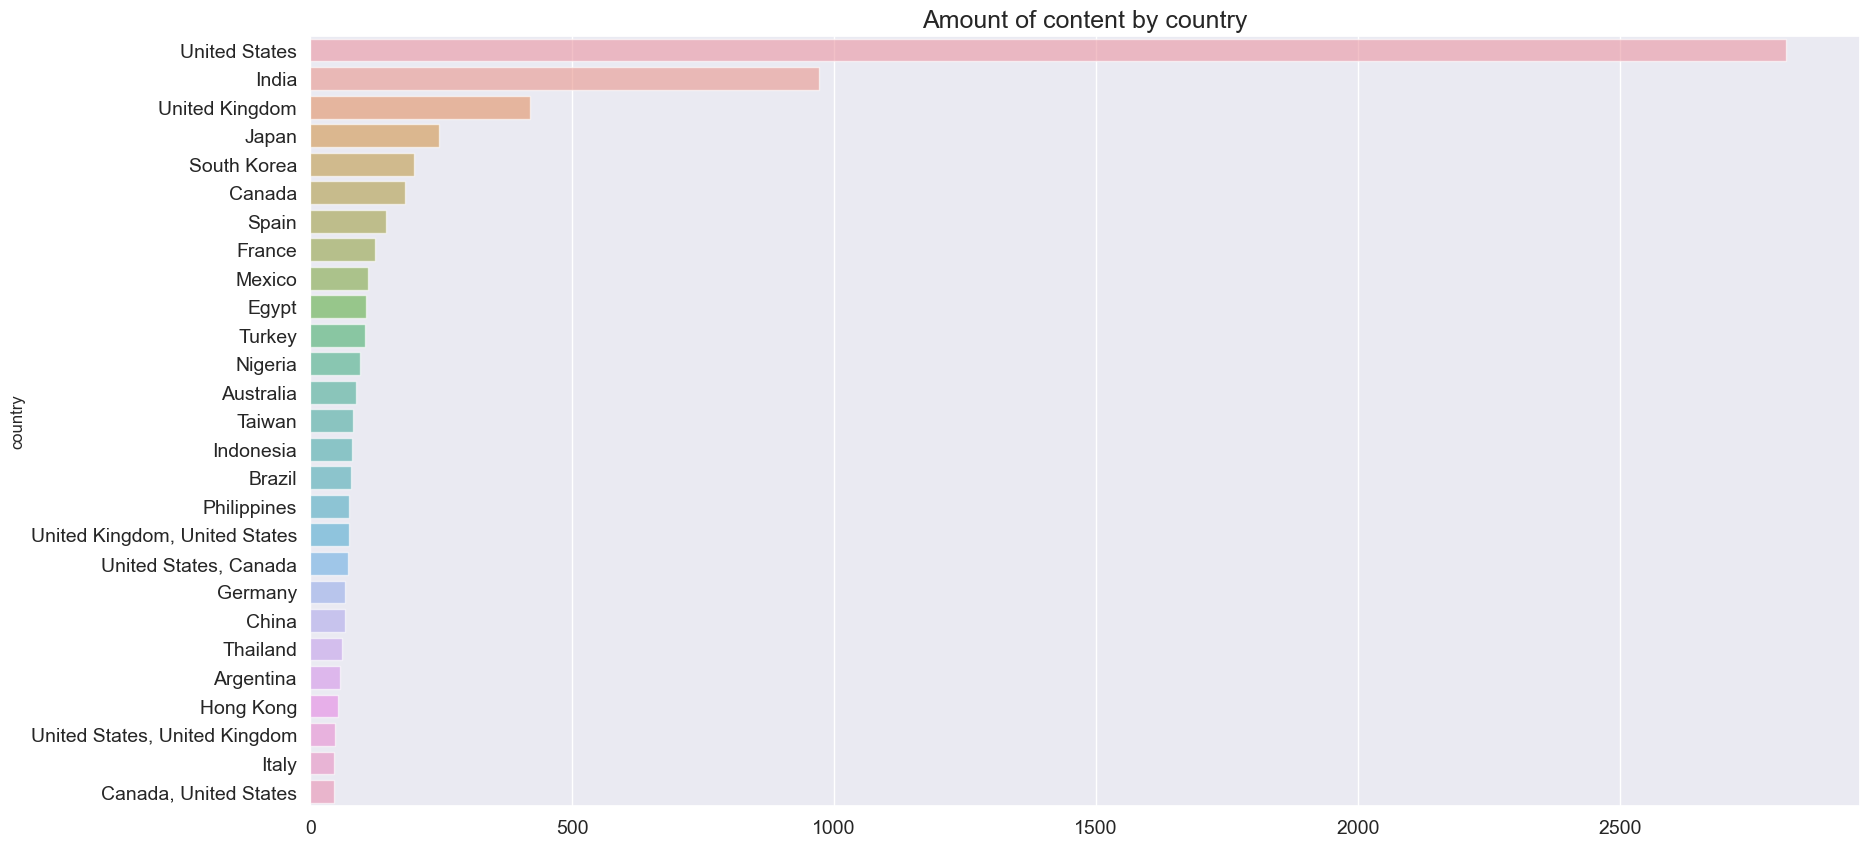

In [201]:
# Amount of content by country
countries = df['country'].value_counts()[df['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)
plt.figure(figsize=(20,10))
plt.title('Amount of content by country', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=countries.index, x=countries.values, alpha=0.6)
plt.show()

The largest amount of content is provided by America, followed by India and UK

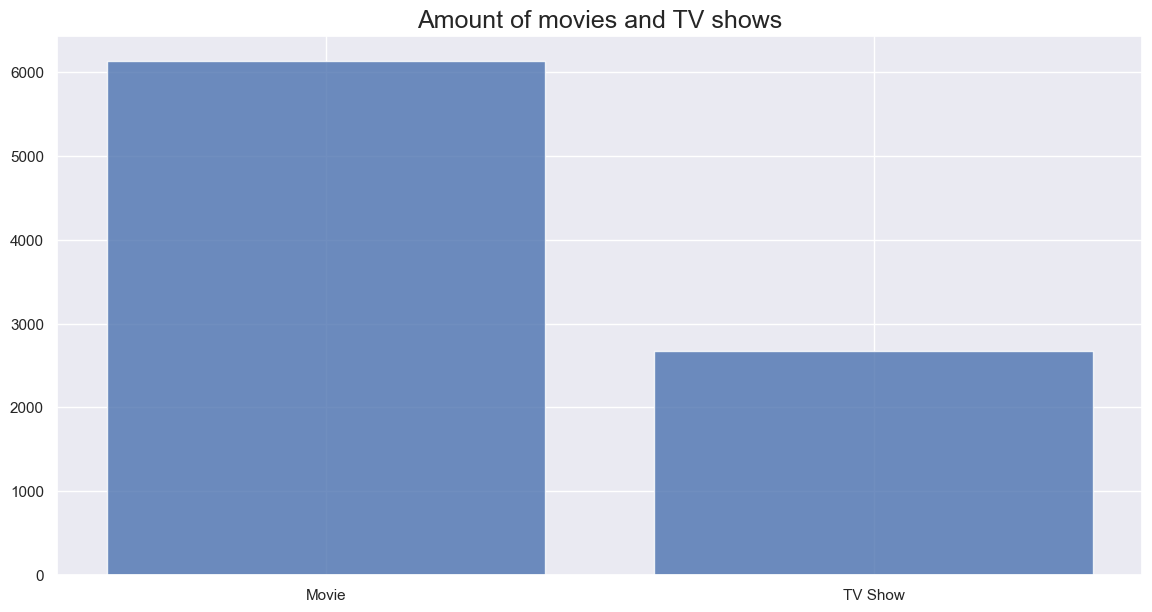

In [202]:
movie_tvshows = df['type'].value_counts()
plt.figure(figsize=(14, 7))
plt.bar(movie_tvshows.index, movie_tvshows.values, alpha=0.8)
plt.title('Amount of movies and TV shows', fontsize=18)
plt.show()

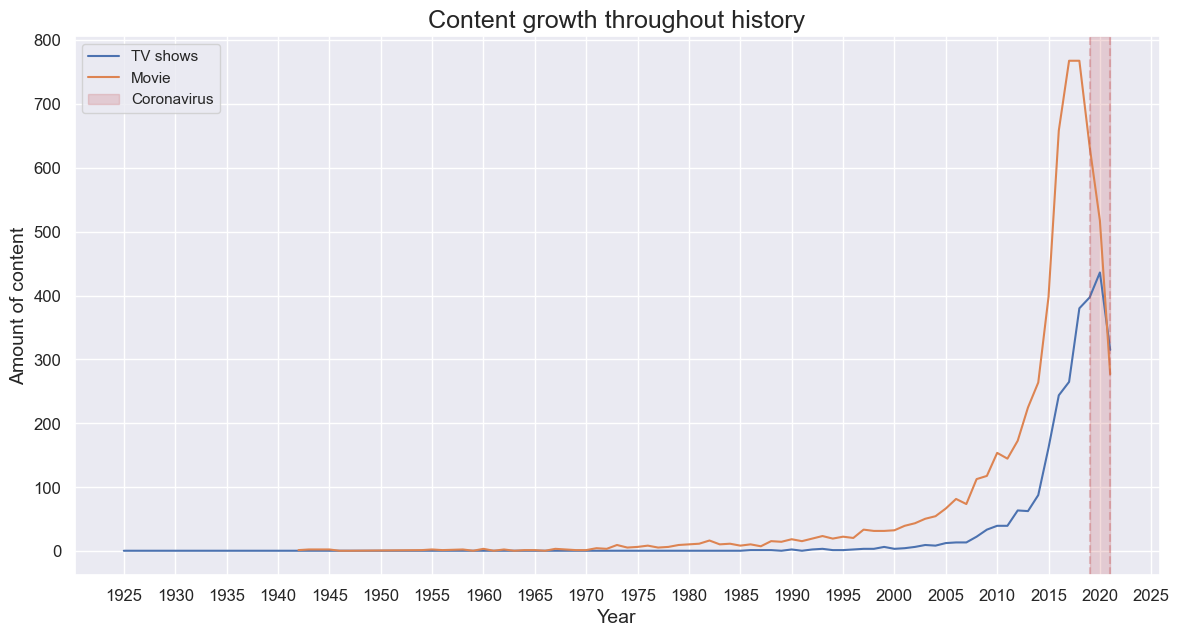

In [203]:
TVshows = df[df['type'] == 'TV Show']
Movie = df[df['type'] == 'Movie']
TVshows_progress = TVshows['release_year'].value_counts().sort_index()
Movie_progress = Movie['release_year'].value_counts().sort_index()
plt.figure(figsize=(14, 7))

plt.plot(TVshows_progress.index, TVshows_progress.values, label='TV shows')
plt.plot(Movie_progress.index, Movie_progress.values, label='Movie')

plt.axvline(2019, alpha=0.3, linestyle='--', color='r')
plt.axvline(2021, alpha=0.3, linestyle='--', color='r')
plt.axvspan(2019, 2021, alpha=0.2, color='r', label='Coronavirus')

plt.xticks(list(range(1925, 2026, 5)), fontsize=12)
plt.title('Content growth throughout history', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount of content', fontsize=14)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

The content amount grew before and during the coronavirus period.

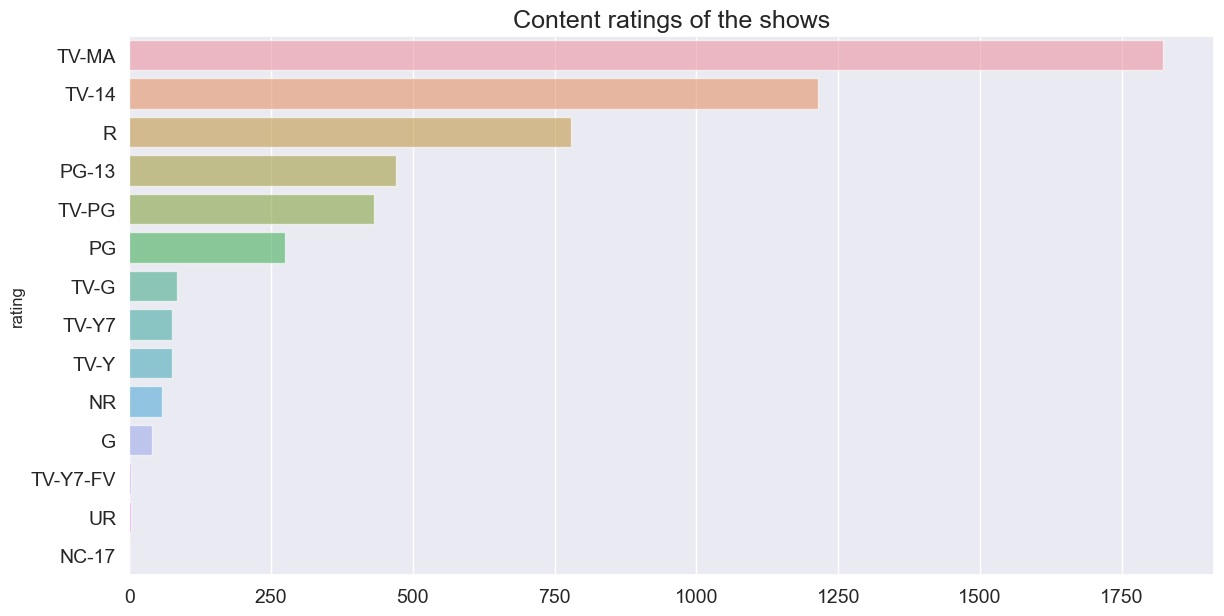

In [204]:
df.dropna(inplace=True)
rating = df['rating'].value_counts()
plt.figure(figsize=(14,7))
plt.title('Content ratings of the shows', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=rating.index, x=rating.values, alpha=0.6)
plt.show()

Inference

The largest count of shows are made with the 'TV-MA' rating (2863 shows) "TV-MA": For mature audiences only.

Second largest is the 'TV-14' rating (1931 shows) "TV-14": May be inappropriate for children younger than 14 years of age.

Third largest is the 'TV-PG' rating (806 shows) "TV-PG": Parental guidance suggested

Fourth largest is the very popular 'R' rating (665 shows) "R": May be unsuitable for children under the age of 17 (Under 17 requires accompanying parent or adult guardian")

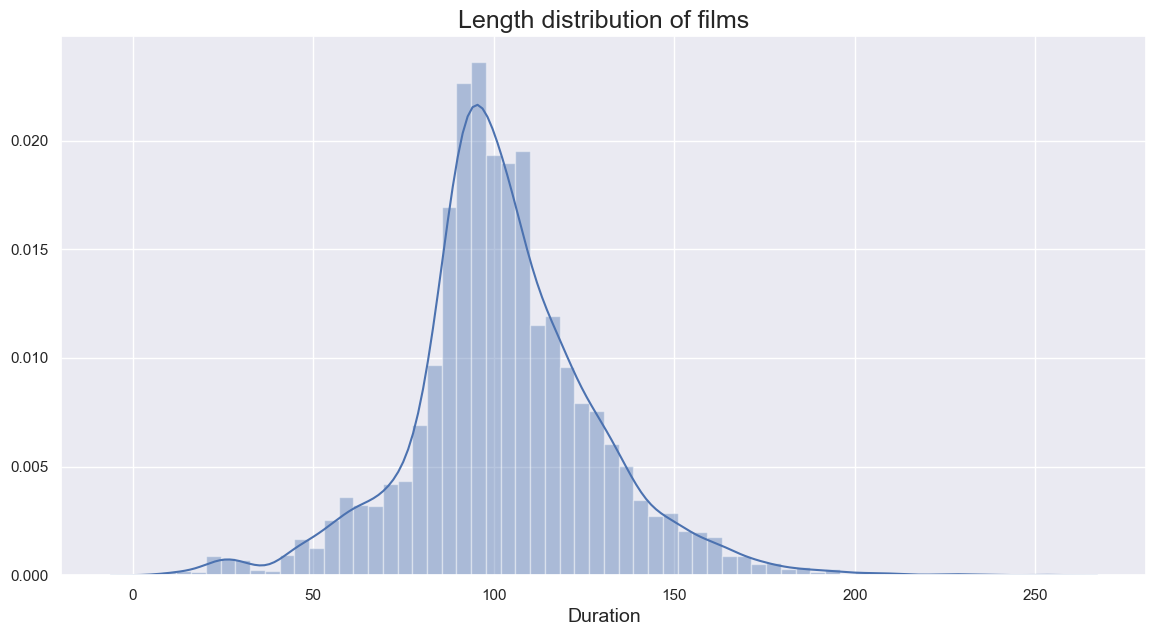

In [205]:
grp = df.groupby('type')
movie = grp.get_group('Movie')
movie['duration'] = [int(i.split(' ')[0]) for i in movie.duration.dropna()]
plt.figure(figsize=(14, 7))
sns.distplot(movie['duration'], bins=60).set(ylabel=None)
plt.title('Length distribution of films', fontsize=18)
plt.xlabel('Duration', fontsize=14)
plt.show()

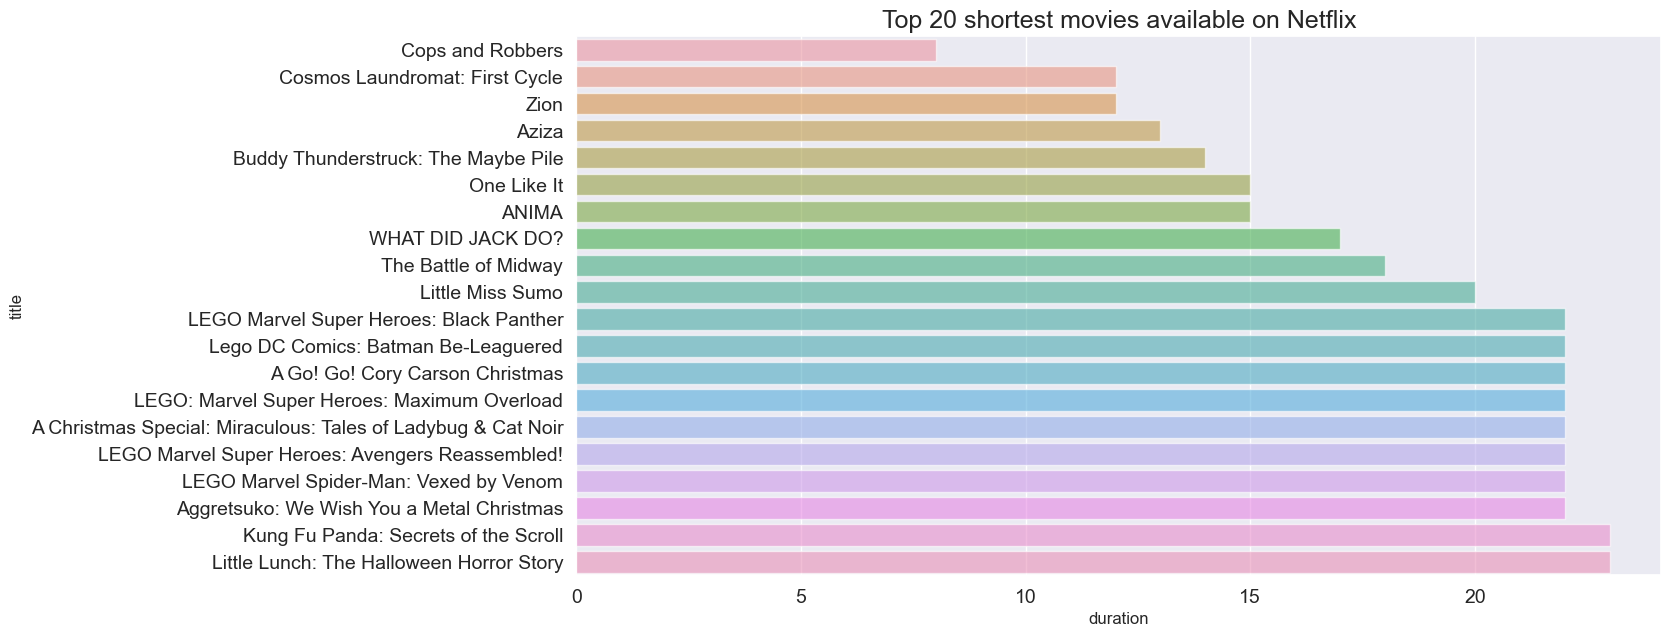

In [206]:
short = movie.sort_values('duration')[['title', 'duration']].iloc[:20]
plt.figure(figsize=(14,7))
plt.title('Top 20 shortest movies available on Netflix', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=short['title'], x=short['duration'], alpha=0.6)
plt.show()

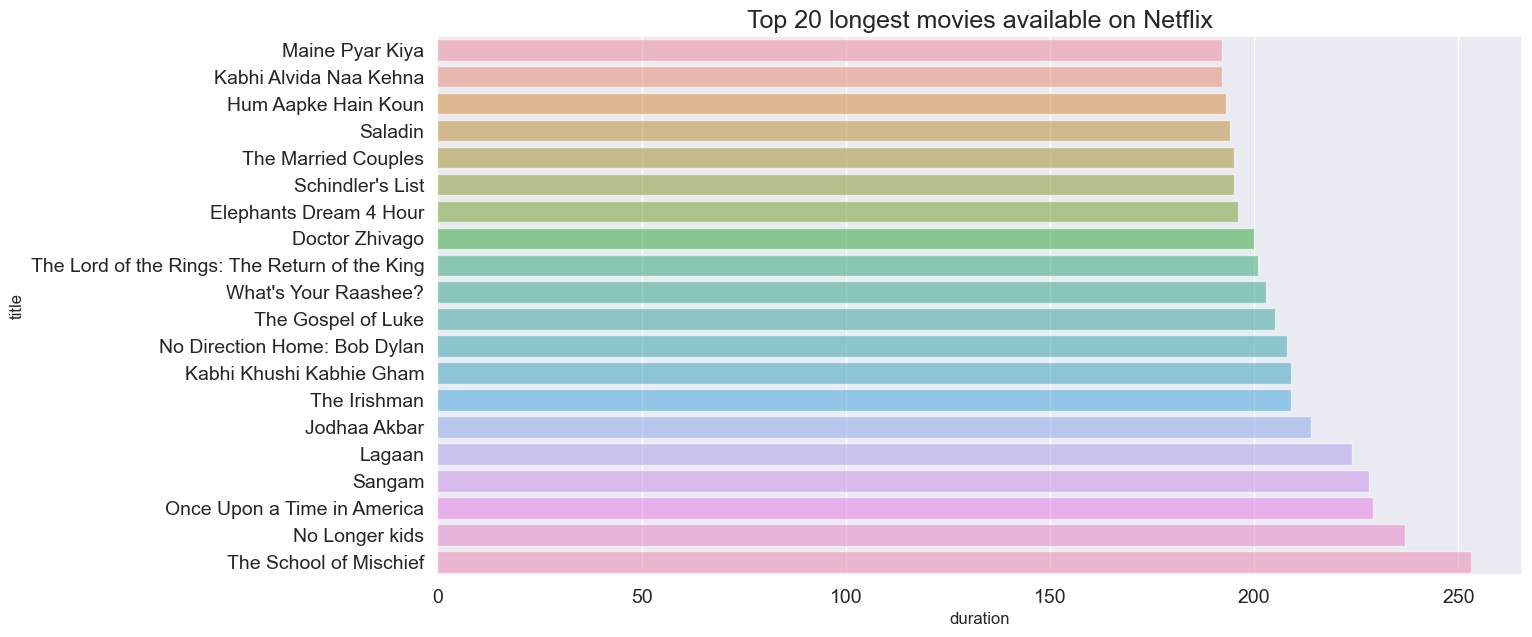

In [207]:
long = movie.sort_values('duration')[['title', 'duration']].iloc[-20:]
plt.figure(figsize=(14,7))
plt.title('Top 20 longest movies available on Netflix', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=long['title'], x=long['duration'], alpha=0.6)
plt.show()

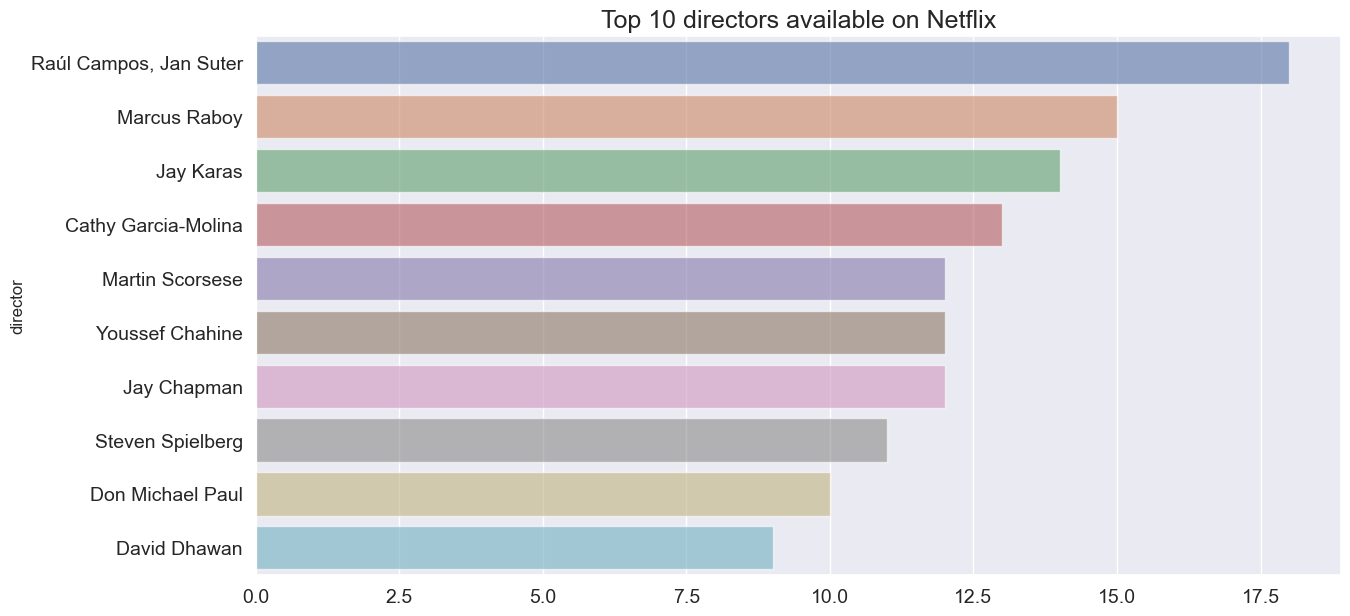

In [208]:
directors = df['director'].value_counts()
plt.figure(figsize=(14,7))
plt.title('Top 10 directors available on Netflix', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=directors.index[:10], x=directors.values[:10], alpha=0.6)
plt.show()

ML model

In [209]:
labels = np.hstack([np.array(i.split(', ')) for i in df.listed_in.dropna()])
unique = np.unique(labels)
def generate_label(x):
    genres = x.split(', ')
    label = np.zeros(shape=unique.shape)
    for i in genres:
        for j in range(len(unique)):
            if unique[j]==i:
                label[j]=1
    return label.astype(int)

In [210]:
from tqdm.notebook import tqdm
data = pd.DataFrame()
data['text'] = df.dropna()['description']
data['title'] = df.dropna()['title']
data['label'] = [generate_label(x) for x in tqdm(df.dropna()['listed_in'])]
data[['text', 'label']].head()

  0%|          | 0/5332 [00:00<?, ?it/s]

text  \
7   On a photo shoot in Ghana, an American model s...   
8   A talented batch of amateur bakers face off in...   
9   A woman adjusting to life after a loss contend...   
12  After most of her family is murdered in a terr...   
24  When the father of the man she loves insists t...   

                                                label  
7   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
8   [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...  
12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
24  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...

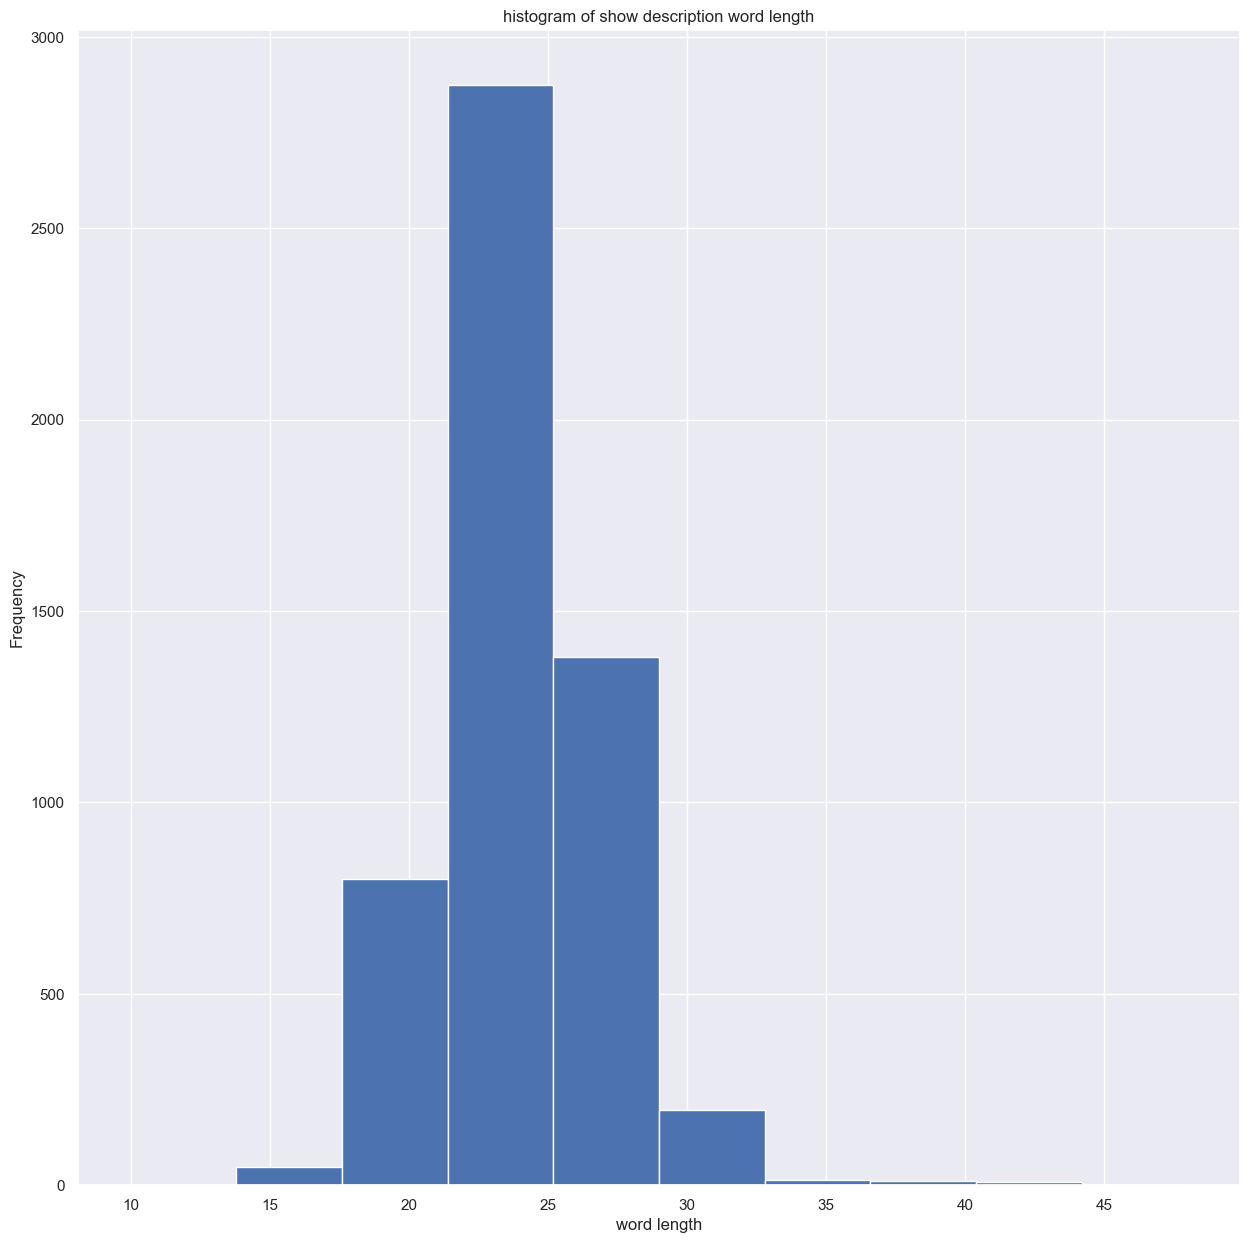

word length at 90 percentile: 27.0
word length at 91 percentile: 28.0
word length at 92 percentile: 28.0
word length at 93 percentile: 28.0
word length at 94 percentile: 28.0
word length at 95 percentile: 28.0
word length at 96 percentile: 29.0
word length at 97 percentile: 29.0
word length at 98 percentile: 29.0
word length at 99 percentile: 31.0


In [211]:
# Let's begin by checking the word length of show descriptions so that
# we can trim and pad the texts to the same length for easy processing in the
#future steps.
def get_wordlen(x):
    return len(x.split())

data['len'] = data.text.apply(get_wordlen)
data['len'].plot(kind='hist')
plt.title('histogram of show description word length')
plt.xlabel('word length')
plt.show()
for i in np.arange(0.9,1,0.01):
    p = data.len.quantile(i)
    print(f'word length at {int(i*100)} percentile:',p)

In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['text', 'title']], data['label'], test_size=0.3, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=33)
y_train.shape, y_val.shape, y_test.shape

((3732,), (800,), (800,))

In [213]:
!pip install bert-tensorflow

In [214]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [215]:
# importing necessary libraries
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalMaxPooling1D
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input
tf.get_logger().setLevel('ERROR')

In [216]:
#Creating a transformer model from pretrained BERT_EN_UNCASED
tf.keras.backend.clear_session()
max_seq_length = 31
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids" )
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False, name='BERT')
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
bert_model = Model(inputs=[input_word_ids, input_mask,segment_ids], outputs=sequence_output)
bert_model.summary(), bert_model.output, bert_model.input

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 31)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 31)]                 0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 31)]                 0         []                            
                                                                                                  
 BERT (KerasLayer)           [(None, 768),                1094822   ['input_word_ids[0][0]',  

(None,
 <KerasTensor: shape=(None, 31, 768) dtype=float32 (created by layer 'BERT')>,
 [<KerasTensor: shape=(None, 31) dtype=int32 (created by layer 'input_word_ids')>,
  <KerasTensor: shape=(None, 31) dtype=int32 (created by layer 'input_mask')>,
  <KerasTensor: shape=(None, 31) dtype=int32 (created by layer 'segment_ids')>])

In [217]:
pip install pydot


Note: you may need to restart the kernel to use updated packages.


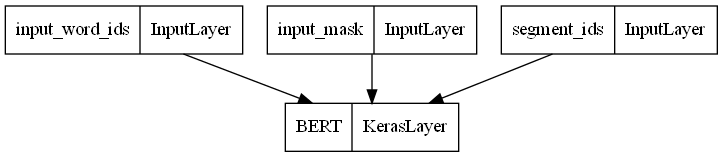

In [218]:
tf.keras.utils.plot_model(bert_model, show_shapes=False, show_dtype=False,
                          show_layer_names=True, rankdir='TB',
                          expand_nested=False, dpi=96)

**Using tokenization to convert the description text into a format understood by BERT**

We'll be creating 3 type of inputs from a given test:

token_ids: The token embeddings are numerical representations of words in the input sentence.

token_masks: The mask tokens that help BERT to understand what all input words are relevant and what all are just there for padding.

token_segments: The segment embeddings are used to help BERT distinguish between the different sentences in a single input.

In [219]:
from bert import tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [220]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def text_to_tokens(x):
    t = np.asarray(tokenizer.tokenize(x))
    if len(t)>max_seq_length-2:
        t = t[:max_seq_length-2]
    padding = np.asarray(['[PAD]']*(max_seq_length-t.shape[0]-2))
    pre, post = np.asarray(['[CLS]']), np.asarray(['[SEP]'])
    final = np.concatenate((pre,t,post,padding))
    ids = np.asarray(tokenizer.convert_tokens_to_ids(final))
    mask = (ids != 0)*1
    segment = np.zeros_like(ids)
    return ids, mask, segment

In [221]:
from tqdm.notebook import tqdm
# initializing lists to collect the generated tokens, masks and segments.
X_train_tokens, X_val_tokens, X_test_tokens = [], [], []
X_train_mask, X_val_mask, X_test_mask = [], [], []
X_train_segment, X_val_segment, X_test_segment = [], [], []
# Generating and storing tokens, masks, segments values for X_train texts
for i,x in tqdm(enumerate(X_train.text.values)):
    t,m,s = text_to_tokens(x)
    X_train_tokens.append(t)
    X_train_mask.append(m)
    X_train_segment.append(s)

# Generating and storing tokens, masks, segments values for X_val texts
for i,x in tqdm(enumerate(X_val.text.values)):
    t,m,s = text_to_tokens(x)
    X_val_tokens.append(t)
    X_val_mask.append(m)
    X_val_segment.append(s)

# Generating and storing tokens, masks, segments values for X_test texts
for i,x in tqdm(enumerate(X_test.text.values)):
    t,m,s = text_to_tokens(x)
    X_test_tokens.append(t)
    X_test_mask.append(m)
    X_test_segment.append(s)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [222]:
### Obtaining the numerical embeddings of text from BERT
# converting the tokens lists to array type
X_train_tokens = np.row_stack(X_train_tokens)
X_val_tokens = np.row_stack(X_val_tokens)
X_test_tokens = np.row_stack(X_test_tokens)
# converting the masks lists to array type
X_train_mask = np.row_stack(X_train_mask)
X_val_mask = np.row_stack(X_val_mask)
X_test_mask = np.row_stack(X_test_mask)
# converting the segment lists to array type
X_train_segment = np.row_stack(X_train_segment)
X_val_segment = np.row_stack(X_val_segment)
X_test_segment = np.row_stack(X_test_segment)

Pooled Output

In [223]:
X_train_pooled_output = bert_model.predict([X_train_tokens, X_train_mask, X_train_segment])
X_val_pooled_output = bert_model.predict([X_val_tokens, X_val_mask, X_val_segment])
X_test_pooled_output = bert_model.predict([X_test_tokens, X_test_mask, X_test_segment])
X_train_pooled_output.shape

25/25 [==============================] - 27s 1s/step


(3732, 31, 768)

Creating a MLP model which can take the BERT embeddings as input and generate predictions.

Since the embeddings are of a dimension (31, 768), we will forst initiale an Input layer of the same dimension, next we'll add a GlobalAveragePooling1D layer to extract 768 embeddings from the input (average for each of the 31 rows) and finally we'll be initializing a Dense layer as the output layer with 42 units and sigmoid as the activation function. Sigmoid is used because each of the 42 outputs could take a value between 0 and 1.

For training the model, we'll use binary_crossentropy as the loss function and Adaptive Momentum (ADAM) as the optimizer.

In [224]:
tf.keras.backend.clear_session()

input_layer = Input((None, 768))
gpa = GlobalAveragePooling1D()(input_layer)
x = Dense(units=64, activation='relu')(gpa)

output_layer = Dense(units=42, activation='sigmoid')(x)

mlp = Model(input_layer, output_layer)
mlp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 768)]       0         
                                                                 
 global_average_pooling1d (  (None, 768)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 42)                2730      
                                                                 
Total params: 51946 (202.91 KB)
Trainable params: 51946 (202.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


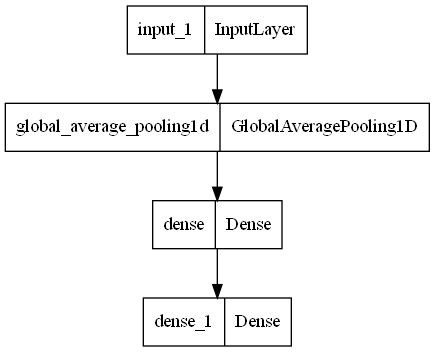

In [225]:
tf.keras.utils.plot_model(mlp, show_shapes=False, show_dtype=False,
                          show_layer_names=True, rankdir='TB',
                          expand_nested=False, dpi=96)

In [226]:
# Performance Metric : Accuracy Score
from sklearn.metrics import accuracy_score
def get_accuracy(y, y_pred):
    acc = []
    for i,j in zip(y, y_pred):
        acc.append(accuracy_score(i,j))
    return np.mean(acc)

def accuracy(y, y_pred):
    return tf.py_function(get_accuracy, (y, tf.cast((y_pred>0.5), tf.float32)), tf.double)

In [227]:
from tensorflow.keras import optimizers
metrics = [accuracy]
mlp.compile(optimizer=optimizers.Adam(0.001), loss='binary_crossentropy', metrics=metrics)

In [228]:
y_train_output = np.vstack(y_train.values)
y_test_output = np.vstack(y_test.values)
y_val_output = np.vstack(y_val.values)

In [229]:
history = mlp.fit(X_train_pooled_output, y_train_output, epochs=35,
                  validation_data=(X_val_pooled_output, y_val_output))

Epoch 1/35
117/117 [==============================] - 6s 45ms/step - loss: 0.1845 - accuracy: 0.9324 - val_loss: 0.1178 - val_accuracy: 0.9544
Epoch 2/35
117/117 [==============================] - 5s 42ms/step - loss: 0.1137 - accuracy: 0.9569 - val_loss: 0.1081 - val_accuracy: 0.9578
Epoch 3/35
117/117 [==============================] - 5s 43ms/step - loss: 0.1054 - accuracy: 0.9599 - val_loss: 0.1048 - val_accuracy: 0.9583
Epoch 4/35
117/117 [==============================] - 5s 43ms/step - loss: 0.1004 - accuracy: 0.9614 - val_loss: 0.1004 - val_accuracy: 0.9602
Epoch 5/35
117/117 [==============================] - 5s 44ms/step - loss: 0.0972 - accuracy: 0.9625 - val_loss: 0.0995 - val_accuracy: 0.9611
Epoch 6/35
117/117 [==============================] - 5s 44ms/step - loss: 0.0944 - accuracy: 0.9635 - val_loss: 0.0968 - val_accuracy: 0.9615
Epoch 7/35
117/117 [==============================] - 5s 43ms/step - loss: 0.0927 - accuracy: 0.9637 - val_loss: 0.0965 - val_accuracy: 0.9625

In [230]:
# Performance Check
df_metric = pd.DataFrame()
df_metric['epoch'] = np.arange(len(history.history['loss']))
df_metric['loss'] = history.history['loss']
df_metric['val_loss'] = history.history['val_loss']
df_metric['accuracy'] = history.history['accuracy']
df_metric['val_accuracy'] = history.history['val_accuracy']

In [231]:
# Train-Val accuracy check
fig = px.line(df_metric, x="epoch", y=["accuracy", 'val_accuracy'])
fig.show()

In [232]:
# Binary cross entropy loss
fig = px.line(df_metric, x="epoch", y=["loss", 'val_loss'])
fig.show()

In [233]:
from sklearn.metrics import accuracy_score
y_pred = (mlp.predict(X_test_pooled_output)>0.5)*1
acc = [accuracy_score(i,j) for i,j in zip(y_pred, y_test)]
idx = np.argsort(acc)[::-1]
def show(i):
    print(f'movie: {X_test.title.values[i]}')
    print(f'description: {X_test.text.values[i]}')
    y_act_idx = unique[np.where(y_test_output[i]==1)]
    y_pred_idx = unique[np.where(y_pred[i]==1)]
    print(f'metric score: {acc[i]}')
    print(f'actual genre: {y_act_idx}')
    print(f'predicted genre: {y_pred_idx}')
    print('\n', '*'*50, '\n')

for i in idx[:10]:
    show(i)

25/25 [==============================] - 0s 3ms/step
movie: The Last Whistle
description: After a star player dies during football practice, his coach’s career and reputation are on the line as he refuses to quit his win-at-all-costs style.
metric score: 1.0
actual genre: ['Dramas' 'Sports Movies']
predicted genre: ['Dramas' 'Sports Movies']

 ************************************************** 

movie: My Travel Buddy
description: Days before Eid, a salesman fired from his job drives to Ayvalık to meet his girlfriend's family, but the trip goes astray due to his zany travel buddy.
metric score: 1.0
actual genre: ['Comedies' 'International Movies']
predicted genre: ['Comedies' 'International Movies']

 ************************************************** 

movie: History of Joy
description: The life of a high-flying law student takes a drastic turn when a bout of misfortune changes his status in society for good.
metric score: 1.0
actual genre: ['Dramas' 'International Movies']
predicted 

In [234]:
# histogram of accuracy scores achieved by the model on the test/unseen dataset.
fig = px.histogram(acc, nbins=20, labels={'value':'Accuracy score'})
fig.show()

In [235]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [236]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

from time import time
import keras.backend as K
#from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Embedding,Layer,InputSpec
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

In [237]:
df_token = dff[ "description"]
#df_token = df_netflix[["listed_in", "description"]].values.tolist()

maxlen = 1500 #only use this number of most frequent words
training_samples = 800
validation_samples = 450
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_token) # generates word index
sequences = tokenizer.texts_to_sequences(df_token) # transforms strings in list of intergers
word_index = tokenizer.word_index # calculated word index
print(f"{len(word_index)} unique tokens found")

data = pad_sequences(sequences, maxlen=maxlen) #transforms integer lists into 2D tensor


20178 unique tokens found


In [238]:
scaler = MinMaxScaler()
x = scaler.fit_transform(data) # the values of all features are rescaled into the range of [0, 1]

In [239]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.

    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10].
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function

    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1

    input_data = Input(shape=(dims[0],), name='input')
    x = input_data

    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)

    decoded = x

    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')

    return autoencoder_model, encoder_model

In [240]:
n_clusters = 30 # max numbers of clusters
n_epochs   = 8 # epchos for autencoder training
batch_size = 128

In [241]:
dims = [x.shape[-1], 500, 500, 1000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = "rmsprop" #SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size

In [242]:
dims

[1500, 500, 500, 1000, 10]

In [243]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform')

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        '''
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)

        inputs: the variable containing data, shape=(n_samples, n_features)

        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.

        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [244]:
autoencoder, encoder = autoencoder(dims, init=init)

In [245]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='binary_crossentropy')  #loss='mse'
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
#autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/8
69/69 [==============================] - 3s 34ms/step - loss: 0.0083
Epoch 2/8
69/69 [==============================] - 2s 33ms/step - loss: 0.0068
Epoch 3/8
69/69 [==============================] - 2s 31ms/step - loss: 0.0067
Epoch 4/8
69/69 [==============================] - 2s 30ms/step - loss: 0.0067
Epoch 5/8
69/69 [==============================] - 2s 30ms/step - loss: 0.0067
Epoch 6/8
69/69 [==============================] - 2s 29ms/step - loss: 0.0067
Epoch 7/8
69/69 [==============================] - 2s 30ms/step - loss: 0.0067
Epoch 8/8
69/69 [==============================] - 2s 31ms/step - loss: 0.0067


In [246]:
#autoencoder.compile(optimizer=pretrain_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)


In [247]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [248]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld') #(optimizer=SGD(0.01, 0.9), loss='kld')

In [249]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

276/276 [==============================] - 1s 4ms/step


In [250]:
y_pred_last = np.copy(y_pred)

In [251]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [252]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [253]:
loss = 0
index = 0
maxiter = 1000 # 8000
update_interval = 100 # 140
index_array = np.arange(x.shape[0])

In [254]:
tol = 0.001 # tolerance threshold to stop training

In [255]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

#model.save_weights(save_dir + '/DEC_model_final.h5')

In [256]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

In [257]:
data_all = dff.copy()

In [258]:
data_all['cluster'] = y_pred
data_all.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  cluster  
0  As her father nears the end of his life, filmm...       19  
1  After crossing paths at a party, a Cape Town t...       21  
2  To protect his family from a powerful drug lor...       18  
3  Feuds, flirtations and toilet talk go down amo...        3  
4  In a city of coaching centers known to train I...       28

In [259]:
data_all['cluster'].value_counts()

cluster
21    573
12    566
2     533
11    452
17    451
6     437
18    422
22    413
16    382
0     378
28    376
3     375
10    330
9     319
7     316
13    312
19    265
26    248
15    234
24    227
5     224
27    175
1     168
20    160
29    144
8     137
4      89
23     57
14     36
25      8
Name: count, dtype: int64

In [260]:
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(x)

x_embedded.shape

(8807, 2)

In [261]:
pip install bokeh

Note: you may need to restart the kernel to use updated packages.


In [262]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup, Div

# Output Bokeh plots to the Jupyter notebook
output_notebook()

# Data sources
source = ColumnDataSource(data=dict(
    x=x_embedded[:, 0],
    y=x_embedded[:, 1],
    titles=dff['title'],
    directors=dff['director'],
    cast=dff['cast'],
    description=dff['description'],
    labels=["C-" + str(x) for x in dff['rating']]
))

# Hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles"),
    ("Director(s)", "@directors"),
    ("Cast", "@cast"),
    ("Description", "@description"),
], point_policy="follow_mouse")

# Map colors
mapper = linear_cmap(field_name='x',
                     palette=Category20[20],
                     low=min(x_embedded[:, 0]), high=max(x_embedded[:, 0]))

# Prepare the figure
scatter_plot = figure(min_width=800, min_height=800,
                      tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'],
                      title="Netflix Movies and Tv Shows, Clustered(Autoencoder and custom Keras Layer), Tf-idf with Plain Text",
                      toolbar_location="right")

# Plot
scatter_plot.scatter('x', 'y', size=5,
                     source=source,
                     fill_color=mapper,
                     line_alpha=0.3,
                     line_color="black",
                     legend_field='labels')

# Option
option = RadioButtonGroup(labels=[f"C-{i}" for i in range(20)] + ["All"],
                          active=20)

# Header
header = Div(text="<h1>Find similar movies / tv shows in corresponding Cluster</h1>")

# Layout
layout = column(header, scatter_plot)

# Show the plot
show(layout)


Loading BokehJS ...

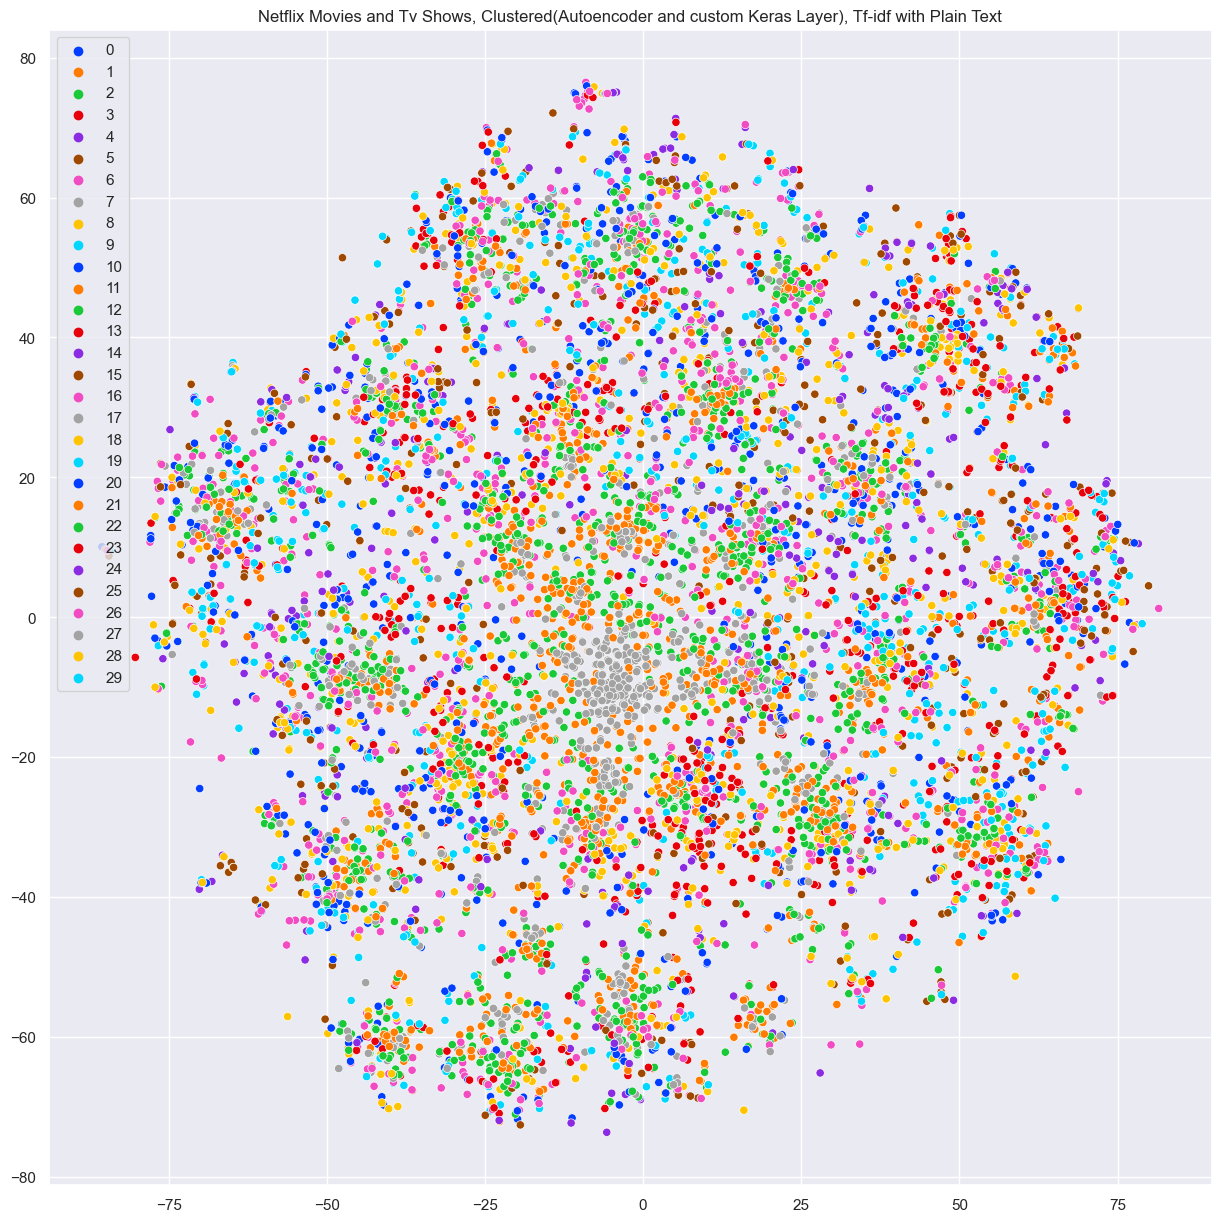

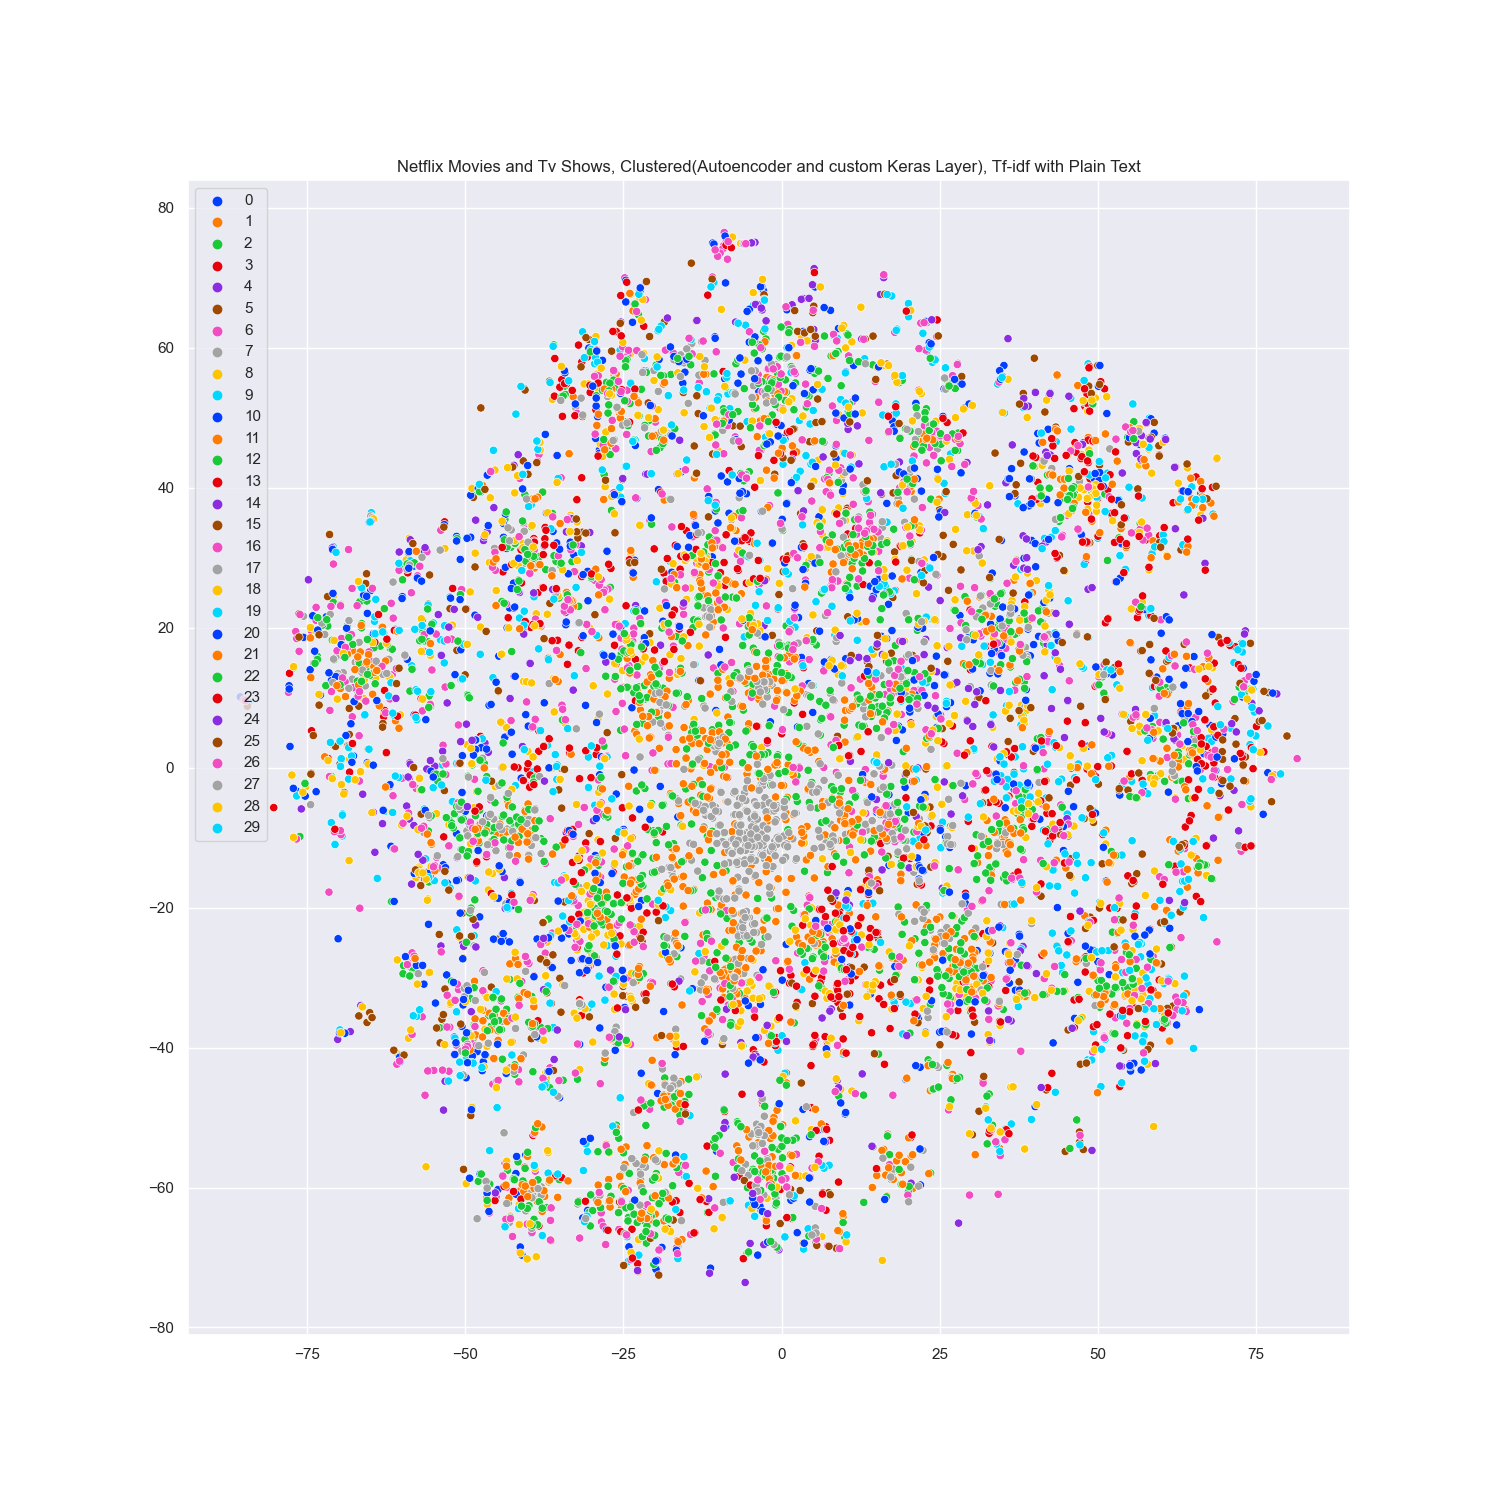

In [263]:
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

# Set Seaborn settings
sns.set(rc={'figure.figsize': (15, 15)})

# Define colors
palette = sns.color_palette("bright", len(set(y_pred)))

# Create a Matplotlib figure
plt.figure(figsize=(15, 15))

# Create scatter plot using Seaborn
scatter_plot = sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=y_pred, legend='full', palette=palette)

# Set plot title using Matplotlib
plt.title("Netflix Movies and Tv Shows, Clustered(Autoencoder and custom Keras Layer), Tf-idf with Plain Text")

# Save the figure
plt.savefig('output2.png')

# Show the plot
plt.show()

# Display the saved image
Image(filename='output2.png')
